In [1]:
import os
from dotenv import load_dotenv
import comet_ml
# from comet_ml import Experiment

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.feature_selection import SelectFromModel, RFE

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, classification_report, PrecisionRecallDisplay, brier_score_loss
from sklearn.calibration import CalibrationDisplay

PATH_REL_PREFIX = '..'
load_dotenv(f'{PATH_REL_PREFIX}/.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question6/YourBestShot-py')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/c351ef25ce8b4a45aad4da6f04539204



In [2]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates


def plot_metrics(pipe):
    params = init_params.copy()
    random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
    random_probs = random_clf.predict_proba(X_val)[:, 1]
    y_val_pred = pipe.predict_proba(X_val)[:,1]

    # Confusion Matrix
    exp.log_confusion_matrix(y_val.to_numpy(), y_val_pred)

    # Classification Report
    exp.log_text(classification_report(y_val, y_val_pred, output_dict=False))

    ### PR Curve -- AUC metric ###
    display = PrecisionRecallDisplay.from_estimator(
        pipe, X_val, y_val, name=f"{init_params['classifier']}"
    )
    display.ax_.set_title("2-class Precision-Recall curve")
    exp.log_figure('PR AUC Curve', display.figure_)

    ### ROC curve - AUC metric ###
    pipe_roc_auc = roc_auc_score(y_val, y_val_pred)
    random_auc = roc_auc_score(y_val, random_probs)
    print('Our Model: ROC AUC=%.3f' % (pipe_roc_auc))
    print('Random: ROC AUC=%.3f' % (random_auc))
    exp.log_metric('ROC AUC', pipe_roc_auc)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, y_val_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{params["classifier"]}')
    plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    exp.log_figure('ROC AUC Curve', plt)
    # plt.savefig('../figures/roc.png')
    plt.show()


    # The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile,
    # i.e. if a value is the 70th percentile, it is above 70% of the data. 
    ### goal_rate = F(shot probability model percentile) ###
    percentiles1, rates1 = compute_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_1.png')
    exp.log_figure('Goal Rate vs Predicted Percentile', plt)
    plt.show()


    # c. The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_2.png')
    exp.log_figure('Cumulative Goal Rate vs Predicted Percentile', plt)
    plt.show()

    # d. The reliability diagram (calibration curve).
    fig, ax = plt.subplots(figsize=(6, 6))
    disp1 = CalibrationDisplay.from_estimator(pipe, X_val, y_val, label=f'{params["classifier"]}', ax=ax)
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_val, y_val, label='Random', ax=ax)
    # plt.savefig('../figures/calibration_diagram.png')
    exp.log_figure('Reliability Diagram', plt)
    plt.show()



def create_pipeline(params):
    encoder = params.get('encoder', 'OrdinalEncoder')
    feature_selection=params.get('feature_selection', None)
    n_features_to_select=params.get('n_features_to_select', 3)
    classifier=params.get('classifier', 'GaussianNB')

    # MLPClassifier
    hidden_layer_sizes=params.get('hidden_layer_sizes', (100,))
    early_stopping = params.get('early_stopping', True)

    # XGBoostClassifier
    max_depth = params.get('max_depth', 6)
    n_estimators = params.get('n_estimators', 100)
    reg_alpha=params.get('reg_alpha', 0)
    reg_lambda=params.get('reg_lambda', 1)
    min_child_weight = params.get('min_child_weight', 1)
    gamma = params.get('gamma', 0)
    subsample = params.get('subsample', 1)
    colsample_bytree = params.get('colsample_bytree', 1)
    use_label_encoder=params.get('use_label_encoder', False)
    tree_method=params.get('tree_method', 'hist')
    gpu_id=params.get('gpu_id', None)


    encoder_map = {
        'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        'OneHotEncoder': OneHotEncoder(handle_unknown='ignore')
    }

    feature_selection_map = {
        'SelectFromModel_LinearSVC': SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False)),
        'RFE_GaussianNB': RFE(GaussianNB(), n_features_to_select=n_features_to_select, step=1),
        'RFE_RandomForestClassifier': RFE(RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators), n_features_to_select=n_features_to_select, step=1),
        'RFE_XGBClassifier': RFE(
            XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                use_label_encoder=use_label_encoder,
                objective='binary:logistic',
                eval_metric='logloss',
                tree_method=tree_method,
                gpu_id=gpu_id,
            ),
            n_features_to_select=n_features_to_select, step=1
        ),
    }

    classifier_map = {
        'GaussianNB': GaussianNB(),
        'RandomForestClassifier': RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators
        ),
        'XGBClassifier': XGBClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            use_label_encoder=use_label_encoder,
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method=tree_method,
            gpu_id=gpu_id,
        ),
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            early_stopping=early_stopping,
        ),
    }

    numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing Data')),
        ('encoder', encoder_map[encoder]),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, make_column_selector(dtype_include="number")),
            ("cat", categorical_transformer, make_column_selector(dtype_exclude="number")),
        ]
    )

    if feature_selection:
        feature_selection = [('feature_selection', feature_selection_map[feature_selection])]
    else:
        feature_selection = []

    pipe = Pipeline(steps=[('preprocessor', preprocessor)] + feature_selection + [('classifier', classifier_map[classifier])])
    
    return pipe


In [3]:
# Load Data
df = pd.read_csv(f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')
df['strength'] = df['strength2']

df['rebound'] = df.rebound.astype(int)
df['Goal'] = df['Goal'].astype(int)
df['EmptyNet'] = df['EmptyNet'].astype(int)

df = df.drop(labels=[
    'totalPlayTime', 'gameID', 'eventType',
    'lastEventPeriodTime',
    'strength2',
    'lastEventAngle',
    'lastEventGameSeconds',
    'emptyNet',
    'lastEventPeriod',
    'xCoord', 'yCoord',
    'lastEventXCoord', 'lastEventYCoord',
    'index',
], axis=1, errors='ignore')



# Train / Valid Split
season_split = 2018
X, y = df.drop(labels='Goal', axis=1), df['Goal']
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index
X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

exp.log_dataset_info(name='trainingSet.csv', version='2021-11-17', path=f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')

for dataset in [X_train, X_val, y_train, y_val]:
    exp.log_dataset_hash(dataset)

X_train.shape, X_train.columns, y_train.shape, y_train.name

((230628, 25),
 Index(['period', 'periodTime', 'periodType', 'teamOfShooter', 'homeOrAway',
        'shooter', 'goalie', 'shotType', 'season', 'rinkSide', 'gameType',
        'lastEventType', 'EmptyNet', 'distanceFromNet', 'angle', 'gameSeconds',
        'timeFromLastEvent', 'distanceFromLastEvent', 'rebound',
        'changeInAngleShot', 'speed', 'timeSincePowerPlayStarted',
        'numFriendlyNonGoalieSkaters', 'numOpposingNonGoalieSkaters',
        'strength2'],
       dtype='object'),
 (230628,),
 'Goal')

In [5]:
init_params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'SelectFromModel_LinearSVC',
    # 'n_features_to_select': 3,
    'classifier': 'MLPClassifier',
}
pipe = create_pipeline(init_params)

param_grid = {
    # 'feature_selection__thershold': ['mean', 'median'],
    'classifier__hidden_layer_sizes': [(10,), (100,), (1000,), (10,10), (100,100), (10,10,10), (100,100,100)],
    'classifier__early_stopping': [True],
}

# Search
tscv = TimeSeriesSplit(2)
search = RandomizedSearchCV(
    pipe, param_grid, cv=tscv, scoring='f1_weighted', random_state=0, verbose=1,
    n_iter=3,
).fit(X, y)
print('BEST PARAMS:', search.best_params_)

COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a2c5439a0>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing '
                                                                           'Data',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/smuchi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
COMET WARNING: truncated string; too long: 'ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4798025970>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing '
                                                                           'Data',
                                                                strategy='constant')),
                                    

BEST PARAMS: {'classifier__hidden_layer_sizes': (100,), 'classifier__early_stopping': True}


In [ ]:
# pipe = search.best_estimator_

In [6]:
# Score
pipe = search.best_estimator_
f1_weighted_scores = cross_val_score(pipe, X, y, scoring='f1_weighted', cv=tscv, n_jobs=-1)
roc_auc_scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=tscv, n_jobs=-1)
print('Weighted F1 SCORES', f1_weighted_scores)
print('Mean Weighted F1 Scores: %.5f' % np.mean(f1_weighted_scores))
print('ROC AUC SCORES', roc_auc_scores)
print('Mean ROC AUC: %.5f' % np.mean(roc_auc_scores))
exp.log_parameter('init_params', init_params)
exp.log_parameter('best_params', search.best_params_)
# exp.log_metric('AUC ROC CV Scores Valid', scores)
exp.log_metric('Weighted F1 CV Mean Score Valid', np.mean(f1_weighted_scores))
exp.log_metric('AUC ROC CV Mean Score Valid', np.mean(roc_auc_scores))


/home/smuchi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/smuchi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/smuchi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/smuchi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Weighted F1 SCORES [0.87269685 0.87021397]
Mean Weighted F1 Scores: 0.87146
ROC AUC SCORES [0.62116409 0.70539713]
Mean ROC AUC: 0.66328


In [11]:
y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)
# logreg_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
# print('Accuracy %s' % accuracy_score(y_pred, y_val))
# print("Model Runtime: %0.2f seconds"%((time.time() - modelstart)))
report = classification_report(y_val, y_pred_val, output_dict=True)
results = pd.DataFrame(report).transpose()
results

,precision,recall,f1-score,support
0,0.908368,0.999464,0.951741,72713.000000
1,0.917548,0.055892,0.105365,7765.000000
accuracy,0.908422,0.908422,0.908422,0.908422
macro avg,0.912958,0.527678,0.528553,80478.000000
weighted avg,0.909254,0.908422,0.870078,80478.000000


In [8]:
print(classification_report(y_val, y_pred_val, output_dict=False))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     72713
           1       0.92      0.06      0.11      7765

    accuracy                           0.91     80478
   macro avg       0.91      0.53      0.53     80478
weighted avg       0.91      0.91      0.87     80478



Text(0.5, 1.0, '2-class Precision-Recall curve')

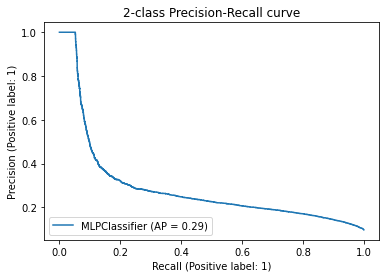

In [9]:
display = PrecisionRecallDisplay.from_estimator(
    pipe, X_val, y_val, name=f"{init_params['classifier']}"
)
display.ax_.set_title("2-class Precision-Recall curve")

In [12]:
brier_score_loss(y_train, y_pred_train), brier_score_loss(y_val, y_pred_val)

(0.08854085366911216, 0.09157782251049977)